In [ ]:
# install dependencies
!pip install intrinio-sdk

In [ ]:
# package imports
from google.colab import userdata

from __future__ import print_function
import time
import intrinio_sdk as intrinio
from intrinio_sdk.rest import ApiException

import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt

## Helper Functions

In [ ]:
def get_all_pages(func, *args, **kwargs):
  intervals = []

  interval_len = -1
  while interval_len != 0 and kwargs['next_page'] is not None:
    response = func(*args, **kwargs)
    interval_len = len(response.intervals)
    intervals.extend(response.intervals)
    kwargs['next_page'] = response.next_page
    # print(response.next_page, interval_len)

  return intervals

In [ ]:
# def get_all_pages_dict(func, *args, **kwargs):
#   intervals = []

#   interval_len = -1
#   while interval_len != 0 and kwargs['next_page'] is not None:
#     response = func(*args, **kwargs)
#     # interval_len = len(response.intervals)
#     # intervals.extend(response.intervals)
#     df = response.get
#     kwargs['next_page'] = response.next_page

#   return intervals

In [ ]:
def build_equity_df(intervals):
  df = pd.DataFrame([ (i.time, i.open, i.close, i.low, i.high, i.volume) for i in intervals ]
                    , columns=['time', 'open_price', 'close_price', 'low_price', 'high_price', 'volume'])

  # adding returns columns (ret_per)
  if df.shape[0] > 0:
    df['ret_per'] = df['close_price'].truediv(pd.concat([pd.Series(0.0), df['close_price']], ignore_index=True))
    df.loc[0, 'ret_per'] = 1
    df['ret_per'] = df['ret_per'] - 1
  else:
    df['ret_per'] = None

  df.sort_values('time')

  return df

In [ ]:
# Assuming 'unusual_options_df' is your DataFrame and 'contract_expiration' column exists
def convert_contract_expiration_to_date(df):
  def convert_to_date(expiration_str):
    if not isinstance(expiration_str, str) or len(expiration_str) < 6:
      return None
    try:
      year = int("20" + expiration_str[:2])  # Assuming year is in the 2000s
      month = int(expiration_str[2:4])
      day = int(expiration_str[4:6])
      return dt.date(year, month, day)
    except ValueError:
      return None

  df['contract_expiration'] = df['contract'].str.extract(r'(\d+)')
  df['contract_expiration_date'] = df['contract_expiration'].apply(convert_to_date)
  return df

In [ ]:
# Assuming 'unusual_options_df' is your DataFrame
def calculate_cumulative_columns(df):
  df = df.sort_values(['contract_expiration_date', 'timestamp'])
  df['cumulative_total_value'] = 0
  df['cumulative_total_size'] = 0

  for expiration_date in df['contract_expiration_date'].unique():
    temp_df = df[df['contract_expiration_date'] == expiration_date]
    cumulative_value = 0
    cumulative_size = 0
    for index, row in temp_df.iterrows():
      if row['contract_expiration_date'] >= dt.date.today():
        cumulative_value += row['total_value']
        cumulative_size += row['total_size']
        df.loc[index, 'cumulative_total_value'] = cumulative_value
        df.loc[index, 'cumulative_total_size'] = cumulative_size

  return df

## Query Functions

In [ ]:
intrinio.ApiClient().set_api_key('OmUwNzdjOGE0YjhhMjFhZDdmZTU2Yzk5ODgzMTIzNzI5')
intrinio.ApiClient().allow_retries(True)

### Equities Query

In [ ]:
# equity data query
# using EST

def getEquityIntervals(identifier: str, interval: str, start_date_: dt.date, end_date_: dt.date):
  source = 'realtime'
  start_time = '000000'
  end_time = '235900'
  timezone = 'America/New_York'
  page_size = 500
  split_adjusted = False
  include_quote_only_bars = False
  next_page = ''

  return get_all_pages(intrinio.SecurityApi().get_security_interval_prices
                       , identifier
                       , interval
                       , source=source
                       , start_date=start_date_.strftime('%Y-%m-%d')
                       , start_time=start_time
                       , end_date=end_date_.strftime('%Y-%m-%d')
                       , end_time=end_time
                       , timezone=timezone
                       , page_size=page_size
                       , split_adjusted=split_adjusted
                       , include_quote_only_bars=include_quote_only_bars
                       , next_page=''
                       )


In [ ]:
# Unusual Options Activity Query

from __future__ import print_function
import time
import intrinio_sdk as intrinio
from intrinio_sdk.rest import ApiException

# activity_type = "block, sweep, large"
# sentiment = "Bullish, Bearish, Neurtal"
def getOptionsData(ticker: str,
                        minimum_value,
                        maximum_value,
                        start_date_: dt.date,
                        end_date_: dt.date):
  next_page = ''
  page_size = 500
  activity_type = ["sweep", "large"]
  sentiment = ["bullish", "bearish"]
  start_date = start_date_.strftime('%Y/%m/%d')
  end_date = end_date_.strftime('%Y/%m/%d')
  minimum_total_value = minimum_value
  maximum_total_value = maximum_value
  df = pd.DataFrame()


  for activity in activity_type:
    for sent in sentiment:
      response = intrinio.OptionsApi().get_unusual_activity_intraday(ticker,
                                                                    next_page=next_page,
                                                                    page_size=page_size,
                                                                    activity_type=activity,
                                                                    sentiment=sent,
                                                                    start_date=start_date,
                                                                    end_date=end_date,
                                                                    minimum_total_value=minimum_total_value,
                                                                    maximum_total_value=maximum_total_value)
    pd.DataFrame.from_dict(response.trades_dict)
    df = pd.concat([df, pd.DataFrame.from_dict(response.trades_dict)])

  return df

### Example

In [ ]:
# prompt: get me the top 50 S&P 500 stocks in a dataframe

import pandas as pd

# Replace with your actual S&P 500 stock tickers
sp500_stocks = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'TSLA', 'BRK.B', 'UNH', 'NVDA', 'JNJ', 'V', 'PG', 'JPM', 'XOM', 'LLY', 'HD', 'MA', 'MRK', 'CVX', 'KO', 'COST', 'PEP', 'AVGO', 'ABBV', 'MCD', 'WMT', 'ACN', 'ADBE', 'CRM', 'CSCO', 'ABT', 'TMO', 'NKE', 'PFE', 'NEE', 'DHR', 'CMCSA', 'INTC', 'QCOM', 'LIN', 'RTX', 'IBM', 'VZ', 'DIS', 'BMY', 'AMT', 'ORCL', 'LOW', 'SPGI', 'AMGN', 'TXN', 'SCHW', 'MDLZ', 'BAC', 'GS']


# Create a DataFrame with the top 50 stocks
top_50_sp500 = pd.DataFrame({'Ticker': sp500_stocks[:50]})

top_50_sp500

,Ticker
0,AAPL
1,MSFT
2,AMZN
3,GOOG
4,TSLA
5,BRK.B
6,UNH
7,NVDA
8,JNJ
9,V


In [ ]:
start_date = dt.date(2024, 10, 1)
end_date = dt.date(2024, 10, 19)
symbol = 'SPY'

unusual_options_df = getOptionsData(symbol, 100000, 10000000, start_date, end_date).sort_values(['total_value', 'total_size'])
unusual_options_df = convert_contract_expiration_to_date(unusual_options_df)
unusual_options_df = calculate_cumulative_columns(unusual_options_df)

# unusual_options_df.drop(columns=['average_price', 'contract', 'contract_expiration', 'type'])
# or
# unusual_options_df.drop(columns=['timestamp', 'type', 'average_price', 'contract', 'ask_at_execution', 'bid_at_execution', 'underlying_price_at_execution', 'contract_expiration'])

In [ ]:
# prompt: given unusual_options_df, create two dataframes, each of which aggregates total_value and total_size based on contract_expiration_date. the first dataframe should be for bearish sentiment, the second for bullish sentiment.

# Create a copy of the DataFrame to avoid modifying the original
bearish_df = unusual_options_df[unusual_options_df['sentiment'] == 'bearish'].copy()
bullish_df = unusual_options_df[unusual_options_df['sentiment'] == 'bullish'].copy()


# Aggregate total_value and total_size by contract_expiration_date for bearish sentiment
bearish_aggregated_df = bearish_df.groupby('contract_expiration_date').agg({'total_value': 'sum', 'total_size': 'sum'})

# Aggregate total_value and total_size by contract_expiration_date for bullish sentiment
bullish_aggregated_df = bullish_df.groupby('contract_expiration_date').agg({'total_value': 'sum', 'total_size': 'sum'})


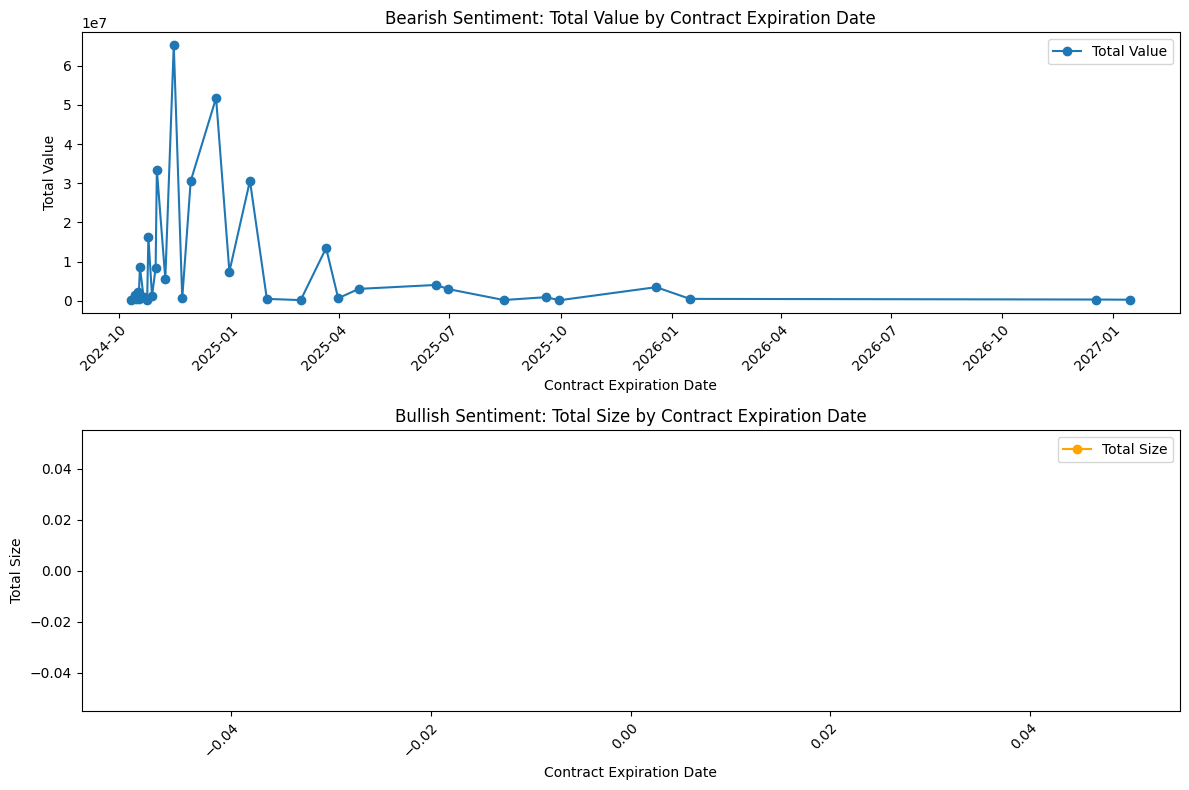

In [ ]:
# prompt: graph bearish_aggregated_df value by contract_expiration_date on one graph and size on another graph

import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot total_value on the first subplot
ax1.plot(bearish_aggregated_df.index, bearish_aggregated_df['total_value'], label='Total Value', marker='o')
ax1.set_xlabel('Contract Expiration Date')
ax1.set_ylabel('Total Value')
ax1.set_title('Bearish Sentiment: Total Value by Contract Expiration Date')
ax1.legend()

# Plot total_size on the second subplot
ax2.plot(bullish_aggregated_df.index, bullish_aggregated_df['total_size'], label='Total Size', marker='o', color='orange')
ax2.set_xlabel('Contract Expiration Date')
ax2.set_ylabel('Total Size')
ax2.set_title('Bullish Sentiment: Total Size by Contract Expiration Date')
ax2.legend()

# Rotate x-axis labels for better readability
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Adjust layout to prevent overlapping
plt.tight_layout()

plt.show()

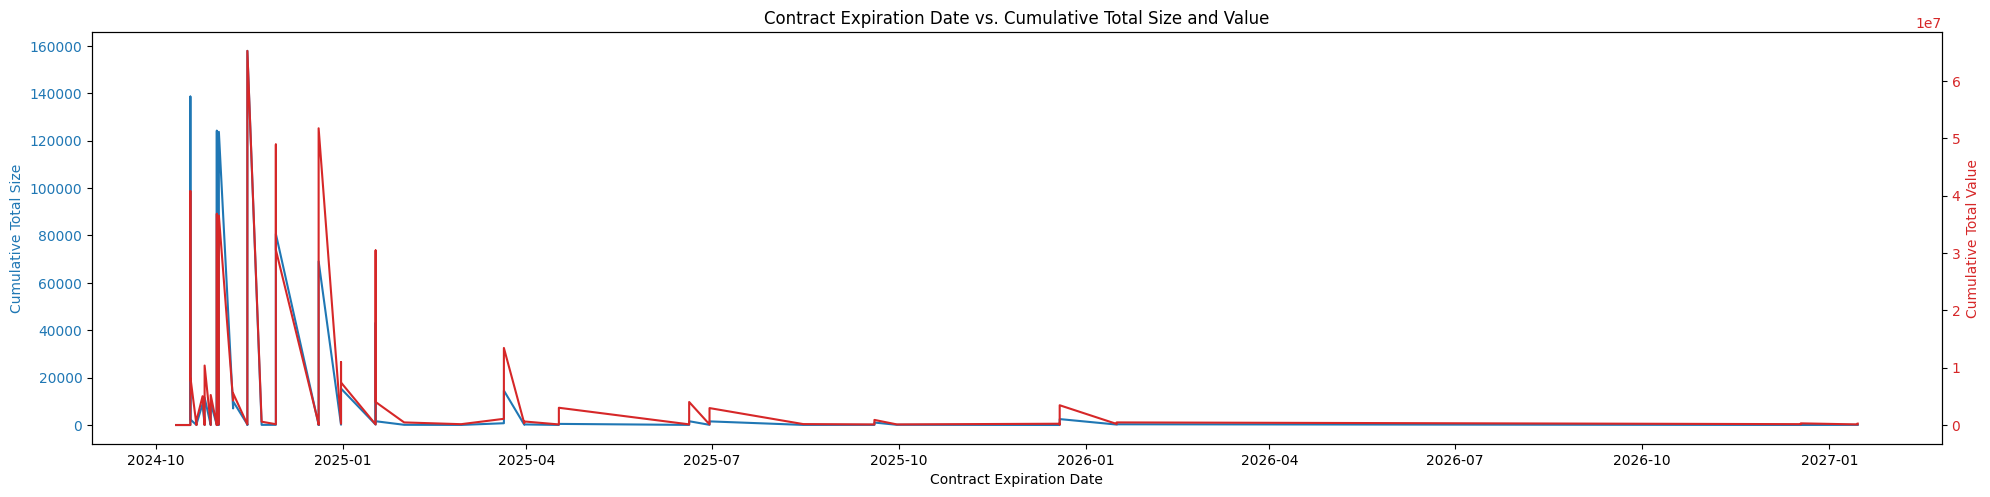

In [ ]:
# prompt: graph contract_expiration_date and cumulative_total_value and cumulative_total_size. graph size on one y-axis and total value on the other y-axis

import matplotlib.pyplot as plt

# Assuming unusual_options_df is your DataFrame with the necessary columns

fig, ax1 = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(5)

# Plot cumulative_total_size on the left y-axis
color = 'tab:blue'
ax1.set_xlabel('Contract Expiration Date')
ax1.set_ylabel('Cumulative Total Size', color=color)
ax1.plot(unusual_options_df['contract_expiration_date'], unusual_options_df['cumulative_total_size'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for cumulative_total_value
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Cumulative Total Value', color=color)  # we already handled the x-label with ax1
ax2.plot(unusual_options_df['contract_expiration_date'], unusual_options_df['cumulative_total_value'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Contract Expiration Date vs. Cumulative Total Size and Value')
plt.show()

In [ ]:
# build chart for symbol
# NOTE: using 500000 as the min value

def buildGraph(symbol: str, start_date: dt.date, end_date: dt.date):
  stock_df = build_equity_df(getEquityIntervals(symbol, '1h', start_date, end_date))
  unusual_options_df = getOptionsData(symbol, 100000, 10000000, start_date, end_date).sort_values(['total_value', 'total_size'])
  unusual_options_df = convert_contract_expiration_to_date(unusual_options_df)
  unusual_options_df = calculate_cumulative_columns(unusual_options_df)

  fig, ax = plt.subplots(1,1)

  # import plotly.express as px
  # fig = px.scatter(stock_df.time, stock_df.ret_per)
  # fig.show()

  ax.plot(stock_df.time, stock_df.ret_per)
  ax2 = ax.twinx()
  ax2.plot(stock_df.time, stock_df.close_price, 'y')
  fig.set_figwidth(15)
  fig.set_figheight(5)

  for idx, row in unusual_options_df.iterrows():
    date = row['timestamp']
    sentiment = row['sentiment']

    if sentiment == 'bullish':
      color = 'green'
    else:
      color = 'red'
    ax.axvline(x=date, color=color, linestyle='--')

  plt.show()

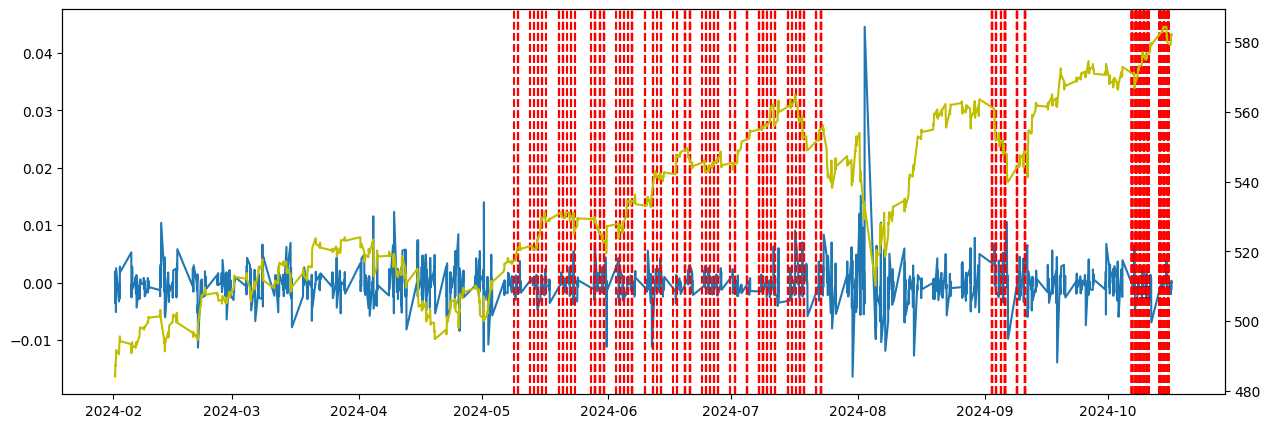

In [ ]:
start_date = dt.date(2024, 2, 1)
end_date = dt.date(2024, 10, 17)
buildGraph('SPY', start_date, end_date)

Lalit 10/25 todo:

1. create a covariance matrix for list of relavent stocks
2. create a backtest
    1. parameters are: size, total value, expiration date range (sell by date?)
3. add factors? (we're mostly looking at tech)
4. find source for earnings dates


Notes - Friday fun :) - Options
* consider a smoothing function or lower floor; de-noise
* consider de-noising function

- Equities:
* need to remove distractions; moves sub 0.5%
  * we need to fix granularity into a day-basis
* need to remove; or flag Earnings dates [do not have data in Api]
* need to manage stock splits/dividends/etc...
5. pull sentiment; we need a single sigal that encapuslates market sentiment (bearish/bullish) and how that impacts trend continuation
6. Do time based decomposition of stock; liklihood of trend continuation

Goal:
* Run granger causality
  * https://medium.datadriveninvestor.com/identifying-leading-indicators-with-granger-causality-test-91815584809a
* Read - https://pmc.ncbi.nlm.nih.gov/articles/PMC10513304/
* Read - https://business.columbia.edu/sites/default/files-efs/imce-uploads/CEASA/Cao%20and%20You%2020210120.pdf

In [ ]:
# prompt: get me the top 50 S&P 500 stocks in a dataframe

import pandas as pd

# Replace with your actual S&P 500 stock tickers
sp500_stocks = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'TSLA', 'BRK.B', 'UNH', 'NVDA', 'JNJ', 'V', 'PG', 'JPM', 'XOM', 'LLY', 'HD', 'MA', 'MRK', 'CVX', 'KO', 'COST', 'PEP', 'AVGO', 'ABBV', 'MCD', 'WMT', 'ACN', 'ADBE', 'CRM', 'CSCO', 'ABT', 'TMO', 'NKE', 'PFE', 'NEE', 'DHR', 'CMCSA', 'INTC', 'QCOM', 'LIN', 'RTX', 'IBM', 'VZ', 'DIS', 'BMY', 'AMT', 'ORCL', 'LOW', 'SPGI', 'AMGN', 'TXN', 'SCHW', 'MDLZ', 'BAC', 'GS']


# Create a DataFrame with the top 50 stocks
top_50_sp500 = pd.DataFrame({'Ticker': sp500_stocks[:50]})

top_50_sp500

,Ticker
0,AAPL
1,MSFT
2,AMZN
3,GOOG
4,TSLA
5,BRK.B
6,UNH
7,NVDA
8,JNJ
9,V


In [ ]:
import os

# USE to download data
# start date 2022-06-01
# end date present

# for symbol in sp500_stocks:
symbol = 'DIS'
start_date = pd.Timestamp(dt.date(2022, 6, 1))
while start_date < pd.Timestamp(dt.date.today()):
  # print(start_date)
  end_date = start_date + pd.DateOffset(months=1)
  equity_df = build_equity_df(getEquityIntervals(symbol, '1h', start_date, end_date))

  # feel free to change to csv
  equity_df.to_parquet(f'{symbol}_{start_date:%Y_%m}_stk.parquet')

  unusual_options_df = getOptionsData(symbol, 100000, 10000000, start_date, end_date).sort_values(['total_value', 'total_size'])
  unusual_options_df = convert_contract_expiration_to_date(unusual_options_df)
  unusual_options_df = calculate_cumulative_columns(unusual_options_df)
  unusual_options_df.to_parquet(f'{symbol}_{start_date:%Y_%m}_optn.parquet')

  start_date = end_date



2022-06-01 00:00:00
2022-07-01 00:00:00
2022-08-01 00:00:00
2022-09-01 00:00:00
2022-10-01 00:00:00
2022-11-01 00:00:00
2022-12-01 00:00:00
2023-01-01 00:00:00
2023-02-01 00:00:00
2023-03-01 00:00:00
2023-04-01 00:00:00
2023-05-01 00:00:00
2023-06-01 00:00:00
2023-07-01 00:00:00
2023-08-01 00:00:00
2023-09-01 00:00:00
2023-10-01 00:00:00
2023-11-01 00:00:00
2023-12-01 00:00:00
2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00
2024-05-01 00:00:00
2024-06-01 00:00:00
2024-07-01 00:00:00
2024-08-01 00:00:00
2024-09-01 00:00:00
2024-10-01 00:00:00


In [ ]:
# Granger Causality

from statsmodels.ts.statstools import grangercausalitytests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# put col1 as time series being granger caused by col2 within a pandas df
gc_res = grangercausalitytests(df, num_lags)


t1 = 0

In [ ]:
https://github.com/rishychacko/auto_trading_strategy